In [38]:
from dataset import *
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import itertools
import numpy as np

# Overlap Pools

In [39]:
df = load_dataframe(r"D:\merged.txt")

## Within pool

In [40]:
overlap_within_pool = df.groupby(['Modified sequence', 'pool']).size().reset_index(name='count')

In [41]:
overlap_within_pool['count'].describe()

count    328933.000000
mean          5.024567
std           6.172815
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         820.000000
Name: count, dtype: float64

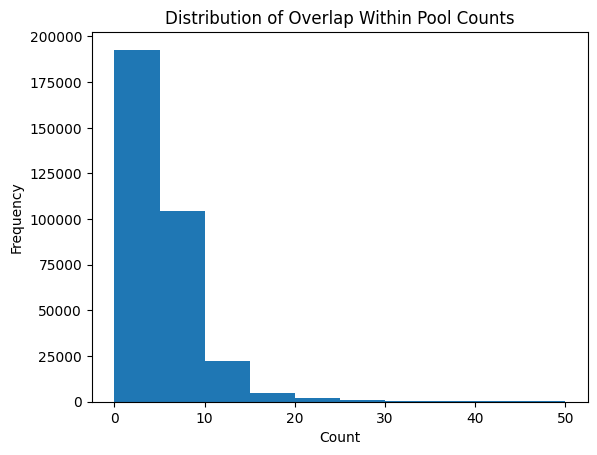

In [42]:
overlap_within_pool["count"].plot.hist(range=(0, 50))
plt.title("Distribution of Overlap Within Pool Counts")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

## Different pool

In [43]:
interaction_matrix = pd.crosstab(df['Modified sequence'], df['pool'])

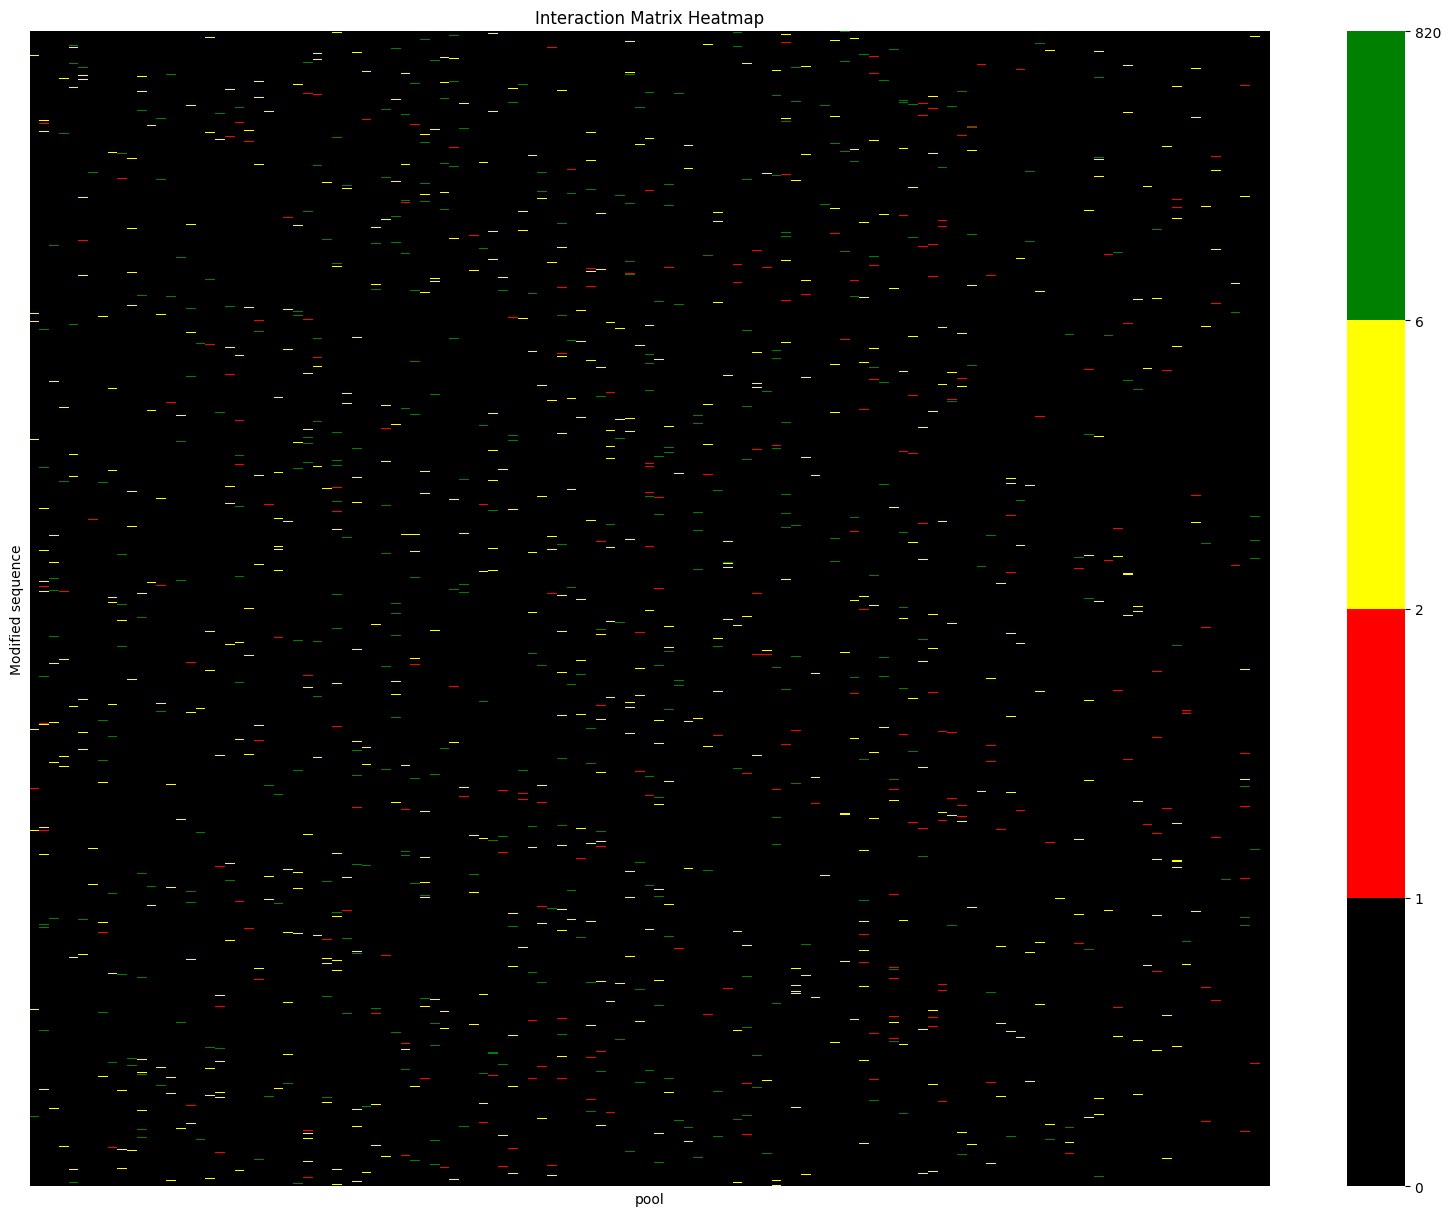

In [44]:
# Define the custom colormap
cmap = ListedColormap(['black', 'red', 'yellow', 'green'])

# Define boundaries for each color (to include intervals properly)
bounds = [0, 1, 2, 6, interaction_matrix.max().max()]  # 0, 1, 2-5, 6+ defined
norm = BoundaryNorm(bounds, cmap.N)

# Set up the figure size
plt.figure(figsize=(20, 15))

# Create the heatmap with the specified colormap and norm for custom value mapping
sns.heatmap(interaction_matrix, cmap=cmap, norm=norm, cbar=True, xticklabels=False, yticklabels=False)

# Add title for better readability
plt.title('Interaction Matrix Heatmap')

# Show the plot
plt.show()

In [45]:
unique_pools_per_sequence = df.groupby('Modified sequence')['pool'].nunique().reset_index()
unique_pools_per_sequence.columns = ['Modified sequence', 'Unique pools']


In [46]:
unique_pools_per_sequence.describe()

,Unique pools
count,292230.000000
mean,1.125596
std,2.011514
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,127.000000


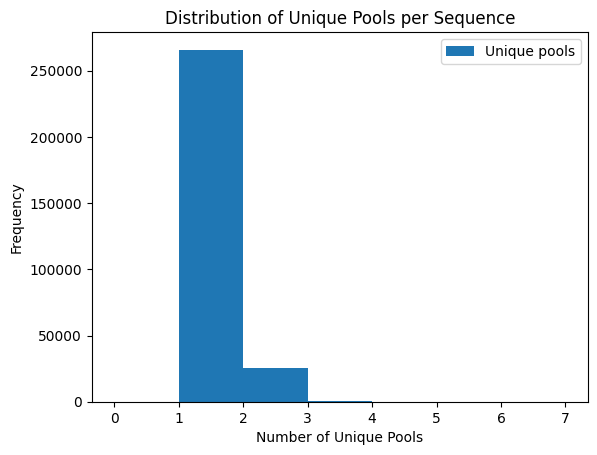

In [47]:
unique_pools_per_sequence.plot.hist(bins=[0, 1, 2, 3, 4, 5, 6, 7], range=(0, 7))
plt.title("Distribution of Unique Pools per Sequence")
plt.xlabel("Number of Unique Pools")
plt.ylabel("Frequency")
plt.show()

# Calculating Mean absolute deviation

In [48]:
def mean_absolute_deviation(series,threshhold):
    if len(series)<threshhold:
        return None
    return (series - series.mean()).abs().mean()

In [49]:
def pairwise_diff_mean(series):
    if len(series)<2:
        return None
    # Generate all pairwise differences
    differences = [abs(a - b) for a, b in itertools.combinations(series, 2)]
    
    # Return the mean of the differences
    return np.mean(differences)

In [50]:
cal_peptides = list(get_calibration_peptides(df).keys())
df_no_calbration_pep = df[~df['Modified sequence'].isin(cal_peptides)]

## Within pool

In [51]:
# Group by peptide sequence and pool, then calculate the variance of 'Score'
within_pool_mad = df.groupby(['Modified sequence', 'pool'])['iRT'].agg(mad = lambda x: mean_absolute_deviation(x, 2),
                                                                      mad_pairs = lambda x: mean_absolute_deviation(x, 2) if len(x)==2 else None,
                                                                    pairwise_diff = lambda x: pairwise_diff_mean(x))

## Across pools

### Option 1 Also include peptides in same pool

In [53]:
across_pool_mad_1 = df_no_calbration_pep.groupby('Modified sequence')['iRT'].agg(mad = lambda x: mean_absolute_deviation(x, 2),
                                                                      mad_pairs = lambda x: mean_absolute_deviation(x, 2) if len(x)==2 else None,
                                                                    pairwise_diff = lambda x: pairwise_diff_mean(x))

### Option 2: Take mean of iRT each peptide in pool get mean absolute deviation across pools

In [55]:
pool_peptide_means = df_no_calbration_pep.groupby(['Modified sequence', 'pool'])['iRT'].agg(lambda x: x.mean()).dropna()
pool_peptide_means = pool_peptide_means.reset_index(name="iRT")

In [56]:
across_pool_mad_2 = pool_peptide_means.groupby('Modified sequence')['iRT'].agg(mad = lambda x: mean_absolute_deviation(x, 2),
                                                                      mad_pairs = lambda x: mean_absolute_deviation(x, 2) if len(x)==2 else None,
                                                                    pairwise_diff = lambda x: pairwise_diff_mean(x))

### Option 3: Sample a iRT each peptide in each pool use this to get mean absolute deviation accros pools

In [72]:
pool_peptide_samples = df_no_calbration_pep.groupby(['Modified sequence', 'pool'])['iRT'].agg(lambda x: np.random.choice(x)).dropna()
pool_peptide_samples = pool_peptide_samples.reset_index(name="iRT")

In [73]:
across_pool_mad_3 = pool_peptide_samples.groupby('Modified sequence')['iRT'].agg(mad = lambda x: mean_absolute_deviation(x, 2),
                                                                      mad_pairs = lambda x: mean_absolute_deviation(x, 2) if len(x)==2 else None,
                                                                    pairwise_diff = lambda x: pairwise_diff_mean(x))

## Compare

In [61]:
test = pd.concat([within_pool_mad.mean(),across_pool_mad_1.mean(),across_pool_mad_2.mean(),across_pool_mad_3.mean()])


<Figure size 1000x600 with 0 Axes>

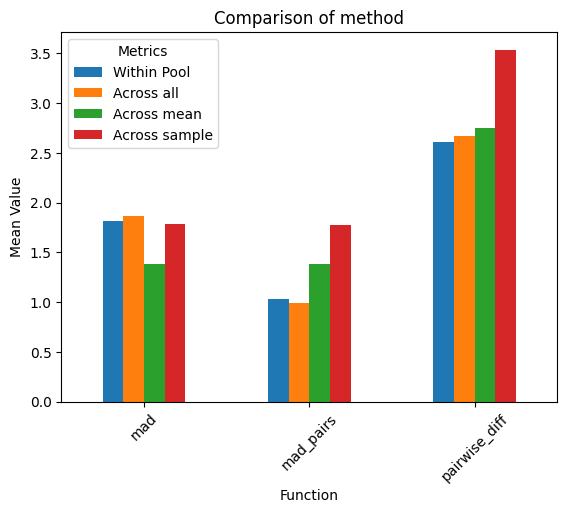

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `test` contains the concatenated means with index labels.
concatenated_pool_stats = pd.concat([
    within_pool_mad.mean().rename("Within Pool"),
    across_pool_mad_1.mean().rename("Across all"),
    across_pool_mad_2.mean().rename("Across mean"),
    across_pool_mad_3.mean().rename("Across sample")
], axis=1)

# Plot
plt.figure(figsize=(10, 6))
concatenated_pool_stats.plot(kind='bar')
plt.xlabel('Function')
plt.ylabel('Mean Value')
plt.title('Comparison of method')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

<Figure size 1000x600 with 0 Axes>

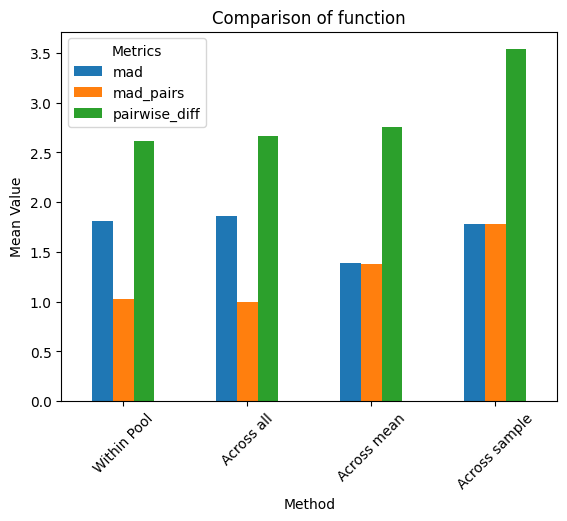

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
concatenated_pool_stats.T.plot(kind='bar')
plt.xlabel('Method')
plt.ylabel('Mean Value')
plt.title('Comparison of function')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()